# Climate Change Sentiment Predictor

This project aims to develop a program that, given a tweet relating to climate change, can predict whether the user's sentiment is sympathetic regarding climate change or not. Using data from a dataset of tweets with a manually labeled sentiment to train from, we aim to help future analysis regarding climate change through this program that looks into human sentiments through tweets. By providing a program that automatically labels sentiments, this project can easily provide future research with numerous and timely data to use.

This project is developed by:

- Alvarado, Enrique Luis
- Bassig, Lance Raphael
- Roxas, Dennis Christian
- Surara, Ron Christian

## 1. Importing the dataset and libraries

In [2]:
pip install nltk

     ---------------------------------------- 1.5/1.5 MB 4.5 MB/s eta 0:00:00
     -------------------------------------- 262.1/262.1 kB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 78.4/78.4 kB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import wordcloud

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('Climate_Sentiments_Twitter.csv')
df.head()

,id,date,retweets,source,author,likes,text,twitter_name,location,verified,followers,friends,polarity,subjectivity,1st review,2nd review,3rd review,sympathy?,"Hidden * change to 'hide' to hide verdict, helpful to avoid biases while reviewing"
0,2.184935e+09,12-22-2020 23:22,71.0,Twitter Web App,GO GREEN,91.0,The death of summer Arctic ice our Earth coole...,ECOWARRIORSS,NaN,False,23415.0,20439.0,-0.054365,0.426984,news,pro,pro,positive,NaN
1,5.086586e+08,12-10-2020 14:30,14.0,Twitter for Advertisers,Elsevier Energy,98.0,Elsevier and the EditorsinChief are pleased to...,ElsevierEnergy,"Oxford, England",False,6615.0,508.0,0.387500,0.633333,news,news,news,positive,*remove the cell above when 3rd reviewer time
2,2.607105e+09,12-22-2020 21:28,0.0,Twitter Web App,Arwyn Thomas,1.0,From better climate change education to improv...,siwarr5,Carmarthen,False,22.0,133.0,0.261905,0.345238,news,neutral,neutral,neutral,NaN
3,1.960966e+07,12-22-2020 21:24,0.0,Twitter Web App,"Tom Gillispie, EDITOR/WRITER",0.0,climate change Links to FIXING CLIMATE CHANGE ...,EDITORatWORK,"Rural Hall, North Carolina, USA",False,4191.0,3708.0,0.000000,0.000000,news,neutral,news,positive,NaN
4,1.960966e+07,12-21-2020 22:52,1.0,Twitter Web App,"Tom Gillispie, EDITOR/WRITER",1.0,climate change The 11TH HOUR FOR THE EARTH cli...,EDITORatWORK,"Rural Hall, North Carolina, USA",False,4191.0,3708.0,0.000000,0.000000,anti,pro,pro,positive,NaN


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\test\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## 2. Data Preprocessing

Since working with a column that has a '?' is troublesome, we will be transforming the 'sympathy?' column to simply 'sympathy'

In [3]:
#Transforming the sympathy? column to sympathy
df.rename(columns={"sympathy?":"sympathy"}, inplace=True)

### 2.1 Data Cleaning

In [4]:
#Dropping unneeded columns
df = df[['text', 'sympathy']]
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,sympathy
0,Climate JC The change in the ENSO teleconnecti...,neutral
1,For years now scientists and governments have ...,positive
2,Do not wait until it is too late fight climate...,positive
3,nytclimate A dream of the climate denier antis...,neutral
4,Dr Ecotone2 of CCYale sat down with GretchenMa...,positive


In [5]:
#Check if there are rows with missing values
df.isna().value_counts()

text   sympathy
False  False       461
dtype: int64

### 2.2 Data Encoding

In [6]:
#Transforming the sympathy column to numerical values using the replacement method
params = {"negative": -1, "neutral": 0, "positive": 1}
df['sympathy'].replace(params, inplace=True)
df.head()

,text,sympathy
0,Climate JC The change in the ENSO teleconnecti...,0
1,For years now scientists and governments have ...,1
2,Do not wait until it is too late fight climate...,1
3,nytclimate A dream of the climate denier antis...,0
4,Dr Ecotone2 of CCYale sat down with GretchenMa...,1


### 2.3 Data Representation

In [7]:
#Creating the feature(s) and target vectors
features = df.drop("sympathy", axis=1)
target = df["sympathy"]

features.head()

,text
0,Climate JC The change in the ENSO teleconnecti...
1,For years now scientists and governments have ...
2,Do not wait until it is too late fight climate...
3,nytclimate A dream of the climate denier antis...
4,Dr Ecotone2 of CCYale sat down with GretchenMa...


### 2.4 Text Data Tokenization

In [8]:
#Tokenize the text data using RegexpTokenizer
textdata = features['text']
n = len(textdata)
tokenizer = RegexpTokenizer(r'\w+')
tokenizedtext = []

for i in range(n):
    #Convert text data to lowercase
    lower = textdata.iloc[i].lower()
    
    #Tokenize
    wordsarray = tokenizer.tokenize(lower)
    tokenizedtext.append(wordsarray)

#print(tokenizedText)

### 2.5 Text Data Cleaning

In [9]:
#Removing stop words using nlkt
englishstopwords = set(stopwords.words('english'))
shortertext = []

for tweet in tokenizedtext:
    shortertweet = []
    for word in tweet:
        if word not in englishstopwords:
            word = word.strip()
            if (word.isdigit() == False and len(word) >= 2):
                shortertweet.append(word)
    shortertext.append(shortertweet)

#print(shorterText)

In [10]:
#Stemming using PorterStemmer
porterstemmer = PorterStemmer()
stemmedtext = []
for tweet in shortertext:
    stemmedwords = []
    for word in tweet:
        stemmedwords.append(porterstemmer.stem(word))
    convertback = ' '.join(stemmedwords)
    stemmedtext.append(convertback)

#Create a separate dataframe dfcv for later EDA
dfcv = df.copy()
dfcv['text'] = stemmedtext

dfcv.head()

,text,sympathy
0,climat jc chang enso teleconnect low global wa...,0
1,year scientist govern discuss debat effect cli...,1
2,wait late fight climat chang need stop global ...,1
3,nytclim dream climat denier antisci privilegec...,0
4,dr ecotone2 ccyal sat gretchenmarg talk americ...,1


### 2.5 Text Data Vectorization

In [11]:
#Vectorizing the text data using TFIDvectorizer for Modelling
tfid = TfidfVectorizer()
vectorizedtfid = tfid.fit_transform(stemmedtext)

#print(vectorizedtfid)
#print(tfid.vocabulary_)

## 3. Exploratory Data Analysis

### 3.1 Distribution of Sentiments

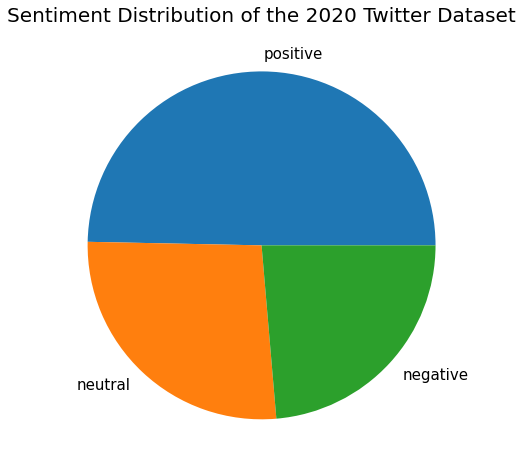

In [12]:
plt.figure(figsize = (8, 8))
values = df['sympathy'].value_counts().values
labels = ['positive', 'neutral', 'negative']
plt.pie(values, labels=labels, textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the 2020 Twitter Dataset', fontsize=20)
plt.show()

### 3.2 Top 30 Occurrences of Words in Sympathetic Climate Change (positive) Tweets

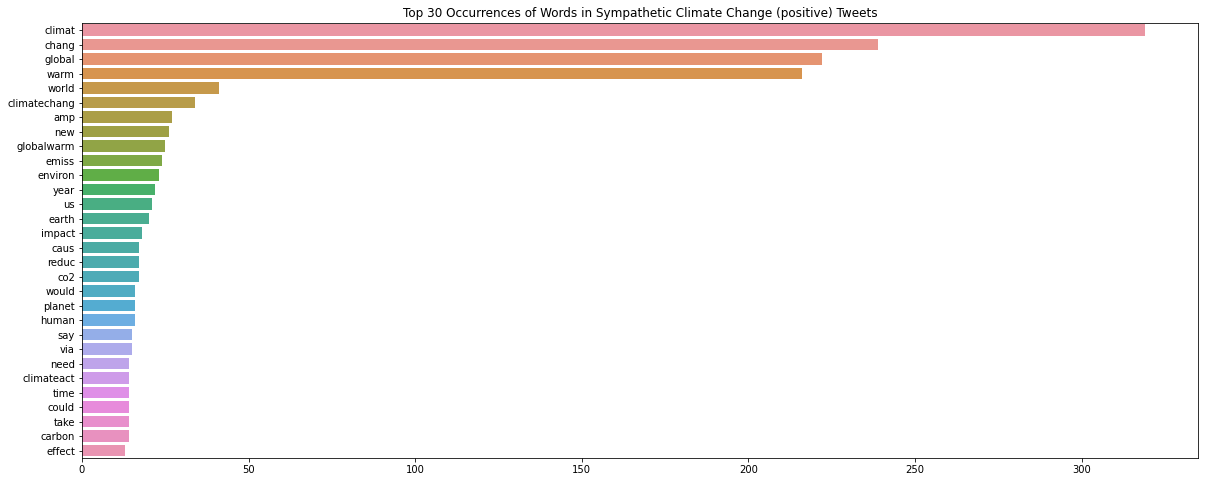

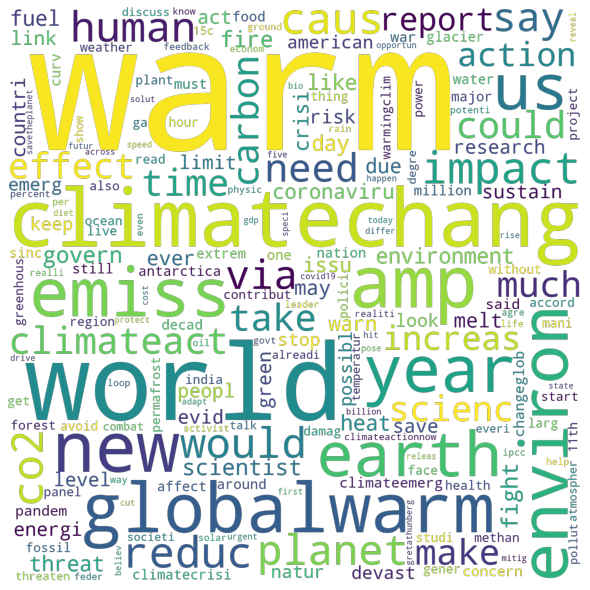

In [55]:
prodict = {}
protweets = dfcv[(dfcv['sympathy'] == 1)]

# wordcloud_str = []

for i in range(protweets.shape[0]):
    wordarray = protweets['text'].iloc[i].split(" ")
    for word in wordarray:
        # wordcloud_str.append(word)
        if word in prodict:
            prodict[word] += 1
        else:
            prodict[word] = 1
            
# wordcloud_stopwords = set([])  # no stopwords; make wordcloud of all words
# wordcloud_str = " ".join(wordcloud_str)  # convert list to str

# gen_wordcloud = wordcloud.WordCloud(width=1600, height=1600,
#                           stopwords=wordcloud_stopwords,
#                           mode="RGBA",
#                           min_font_size=1).generate(wordcloud_str)

# plt.figure(figsize = (8, 8), facecolor = None)
# plt.imshow(gen_wordcloud)
# plt.axis("off")
# plt.tight_layout(pad = 0)
# plt.show()

    
prodict = dict(sorted(prodict.items(), key=lambda item: item[1], reverse=True))
#print(prodict)

plt.figure(figsize=(20,8))
plt.title("Top 30 Occurrences of Words in Sympathetic Climate Change (positive) Tweets")
keys = list(prodict.keys())[:30]
vals = list(prodict.values())[:30]
sns.barplot(x=vals, y=keys)

common_highf_words = ["climat", "chang", "global"]

# generate wordcloud from frequency dictionary

temp_freq_storage = {}

# set frequency common highest-frequency words to 0
for word in common_highf_words:
    temp_freq_storage[word] = prodict[word]
    prodict[word] = 0

# generate wordcloud
gen_wordcloud = wordcloud.WordCloud(width=1600, height=1600,
                           mode="RGBA",
                           background_color=None,
                           min_font_size=1).generate_from_frequencies(frequencies=prodict)

# restore word frequencies
for word in common_highf_words:
    prodict[word] = temp_freq_storage[word]

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(gen_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#print(valuecounts)

### 3.3 Top 30 Occurrences of Words in Aphathetic Climate Change (anti) Tweets

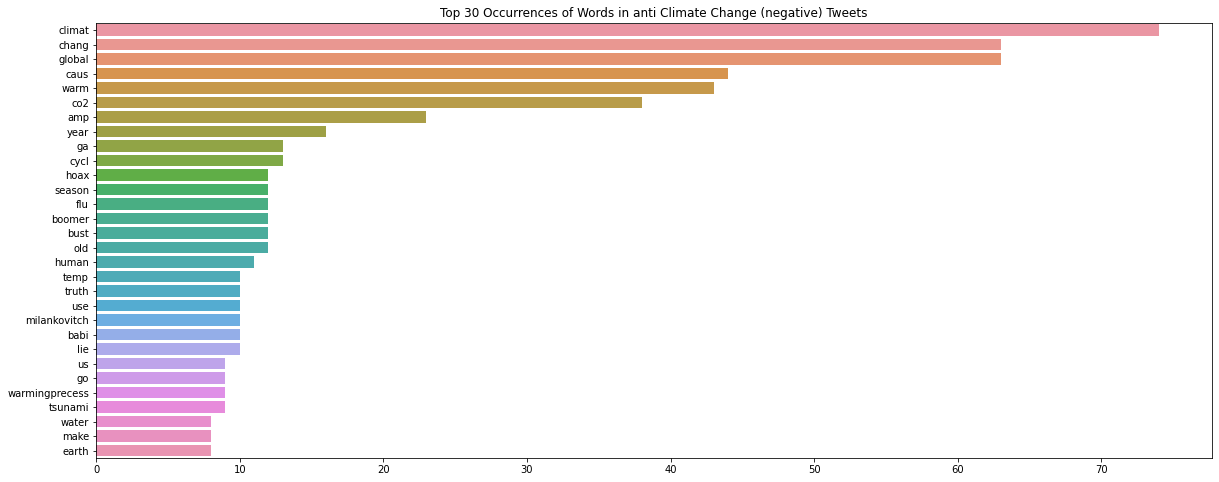

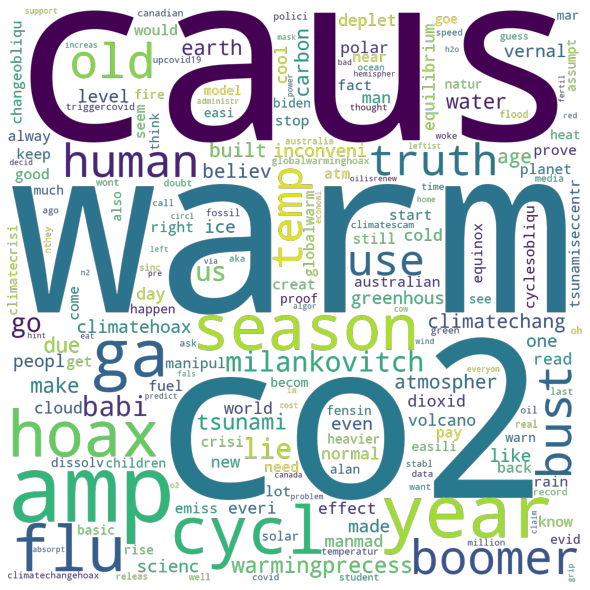

In [56]:
antidict = {}
antitweets = dfcv[(dfcv['sympathy'] == -1)]

for i in range(antitweets.shape[0]):
    wordarray = antitweets['text'].iloc[i].split(" ")
    for word in wordarray:
        if word in antidict:
            antidict[word] += 1
        else:
            antidict[word] = 1

antidict = dict(sorted(antidict.items(), key=lambda item: item[1], reverse=True))
#print(prodict)

plt.figure(figsize=(20,8))
plt.title("Top 30 Occurrences of Words in anti Climate Change (negative) Tweets")
keys = list(antidict.keys())[:30]
vals = list(antidict.values())[:30]
sns.barplot(x=vals, y=keys)

# generate wordcloud from frequency dictionary

temp_freq_storage = {}

# set frequency common highest-frequency words to 0
for word in common_highf_words:
    temp_freq_storage[word] = antidict[word]
    antidict[word] = 0

gen_wordcloud = wordcloud.WordCloud(width=1600, height=1600,
                           mode="RGBA",
                           background_color=None,
                           min_font_size=1).generate_from_frequencies(frequencies=antidict)

# restore word frequencies
for word in common_highf_words:
    antidict[word] = temp_freq_storage[word]


plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(gen_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### 3.4 Top 30 Occurrences of Words in Neutral Climate Change (neutral) Tweets

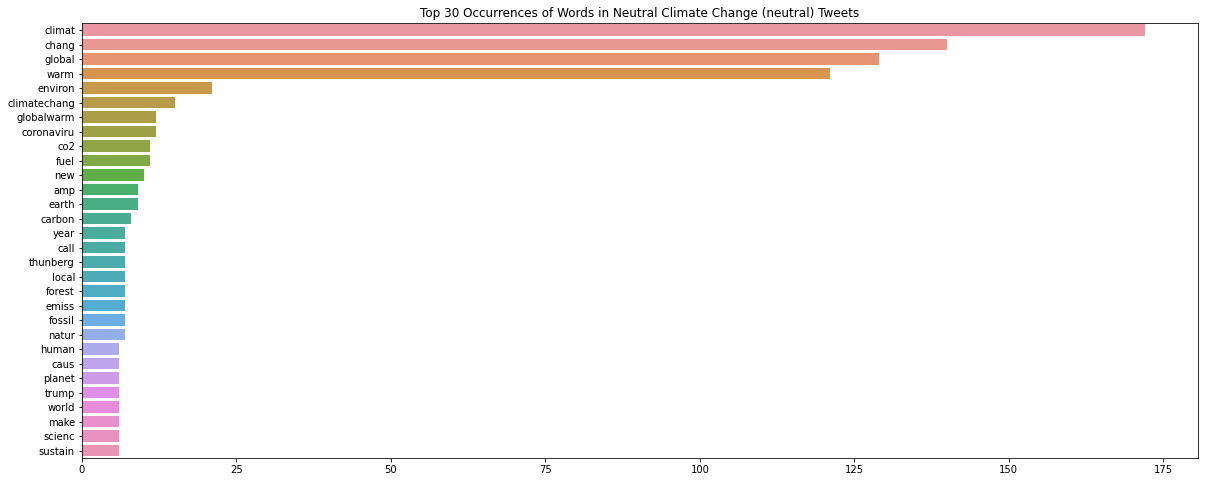

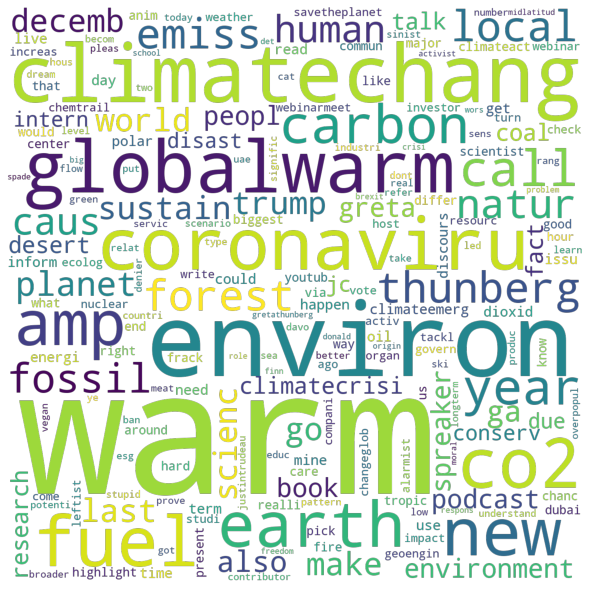

In [57]:
neutraldict = {}
neutraltweets = dfcv[(dfcv['sympathy'] == 0)]

for i in range(neutraltweets.shape[0]):
    wordarray = neutraltweets['text'].iloc[i].split(" ")
    for word in wordarray:
        if word in neutraldict:
            neutraldict[word] += 1
        else:
            neutraldict[word] = 1

neutraldict = dict(sorted(neutraldict.items(), key=lambda item: item[1], reverse=True))
#print(prodict)

plt.figure(figsize=(20,8))
plt.title("Top 30 Occurrences of Words in Neutral Climate Change (neutral) Tweets")
keys = list(neutraldict.keys())[:30]
vals = list(neutraldict.values())[:30]
sns.barplot(x=vals, y=keys)


# generate wordcloud from frequency dictionary

temp_freq_storage = {}

# set frequency common highest-frequency words to 0
for word in common_highf_words:
    temp_freq_storage[word] = neutraldict[word]
    neutraldict[word] = 0

# generate wordcloud
gen_wordcloud = wordcloud.WordCloud(width=1600, height=1600,
                           mode="RGBA",
                           background_color=None,
                           min_font_size=1).generate_from_frequencies(frequencies=neutraldict)


# restore word frequencies
for word in common_highf_words:
    neutraldict[word] = temp_freq_storage[word]

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(gen_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### 3.5. Wordcount comparisons

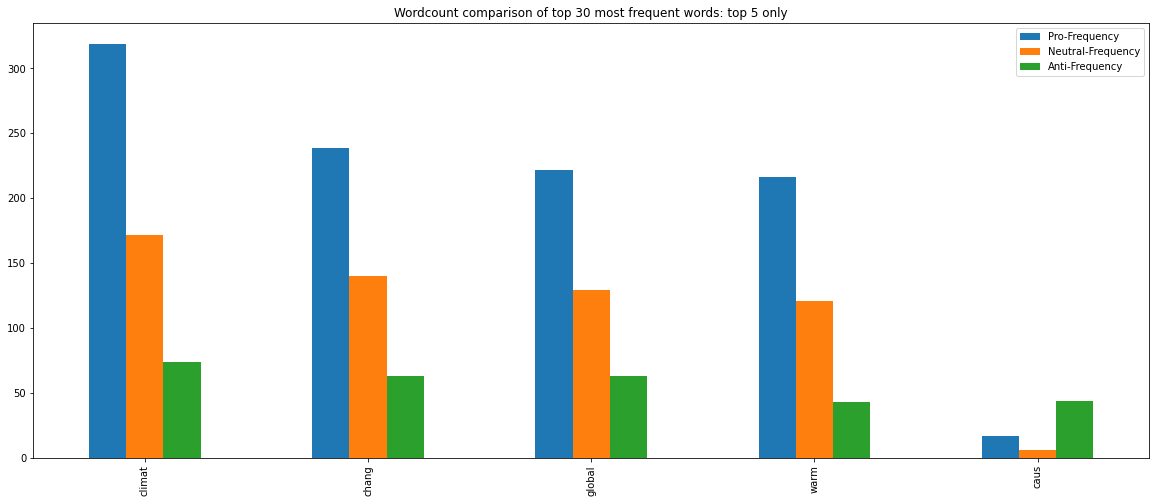

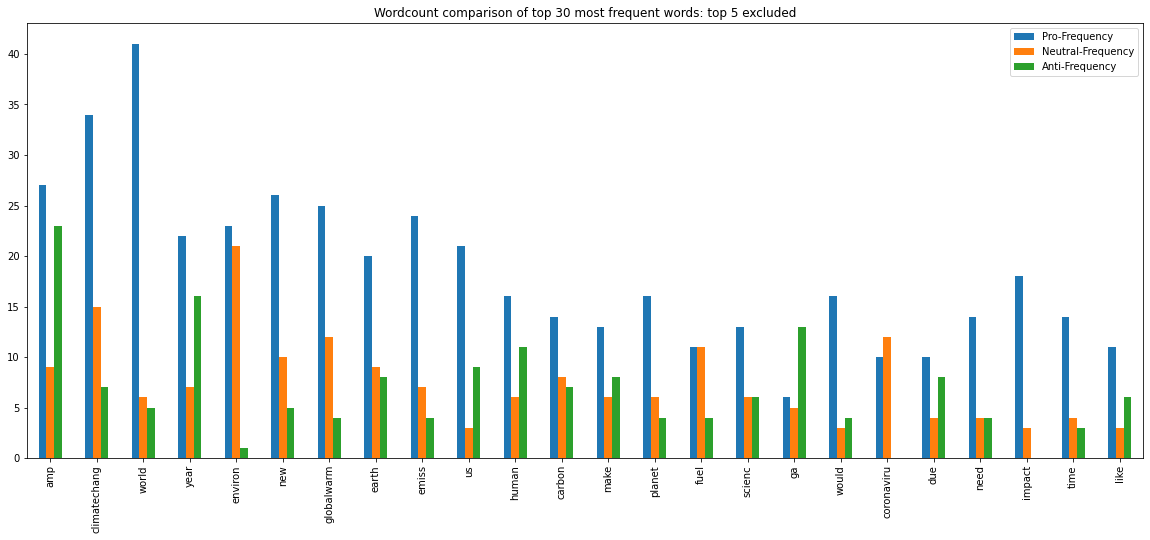

In [109]:
# make a list of all unique words accross tweets
word_compare_labels = set()

for proword, antiword, neutralword in zip(prodict, antidict, neutraldict):
    word_compare_labels.add(proword)
    word_compare_labels.add(antiword)
    word_compare_labels.add(neutralword)

    
word_compare_labels = [*word_compare_labels, ]  # converts set to list of unique words (these are the row labels/indexes)

word_compare_labels_len = len(word_compare_labels)  # take number of words

# goal: make a dataframe to use for plotting a multibar graph

# initialize list of wordcount values (these are the columns)
pro_wordcounts = [0 for i in range(word_compare_labels_len)]
anti_wordcounts = [0 for i in range(word_compare_labels_len)]
neutral_wordcounts = [0 for i in range(word_compare_labels_len)]
sum_wordcounts = [0 for i in range(word_compare_labels_len)]

# assign wordcount values to respective indexes
for i in range(word_compare_labels_len):
    try:
        pro_wordcounts[i] = prodict[word_compare_labels[i]]
    except KeyError:
        pass
    try:
        anti_wordcounts[i] = antidict[word_compare_labels[i]]
    except KeyError:
        pass
    try:
        neutral_wordcounts[i] = neutraldict[word_compare_labels[i]]
    except KeyError:
        pass
    # add "total frequency" column for sorting later
    sum_wordcounts[i] = pro_wordcounts[i] + anti_wordcounts[i] + neutral_wordcounts[i]
    
# make dictionary to turn into dataframe
wordcompare_d = {
    # 'Word': word_compare_labels,
    'Pro-Frequency': pro_wordcounts,
    'Neutral-Frequency': neutral_wordcounts,
    'Anti-Frequency': anti_wordcounts,
    'Total': sum_wordcounts
}

# turn dictionary to dataframe
wordcompare_df = pd.DataFrame(
    data=wordcompare_d,
    index=word_compare_labels
)

# sort
wordcompare_df = wordcompare_df.sort_values(['Total'], ascending=[False])

wordcompare_df.drop(labels="Total", axis=1, inplace=True)

ax = wordcompare_df[:5].plot(title="Wordcount comparison of top 30 most frequent words: top 5 only", figsize=(20, 8), kind="bar")
ax = wordcompare_df[6:30].plot(title="Wordcount comparison of top 30 most frequent words: top 5 excluded", figsize=(20, 8), kind="bar")


# for i in range(5):
#     print(f"%s: (%d, %d, %d)" % (word_compare_labels[i], pro_wordcounts[i], neutral_wordcounts[i], anti_wordcounts[i]))
# wordcompare_df


# X_axis = np.arange(word_compare_labels_len)
  
# plt.bar(X_axis - 0.3, pro_wordcounts, 0.2, label = 'Pro')
# plt.bar(X_axis, neutral_wordcounts, 0.2, label='Neutral')
# plt.bar(X_axis + 0.3, anti_wordcounts, 0.2, label = 'Anti')
  
# plt.xticks(X_axis, word_compare_labels)
# plt.xlabel("Word")
# plt.ylabel("Frequency")
# plt.title("Word Frequency Comparison")
# plt.legend()
# plt.show()


## 4. Data Modelling

### 4.1 Using Logistic Regression

In [110]:
#
# Use "vectorizedtfid" for the features matrix
# and "target" dataframe for the target vector
#

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(vectorizedtfid, target, test_size=0.30, random_state=0)

from sklearn.linear_model import LogisticRegression

for s in ['newton-cg','lbfgs','liblinear']:
    print ("Solver: ", s)
    logisticRegr = LogisticRegression(C=1000000,solver=s,max_iter=1000000)
    logisticRegr.fit(x_train,y_train)
    score = logisticRegr.score(x_test,y_test)
    print("Accuracy Score:", score)

Solver:  newton-cg
Accuracy Score: 0.697841726618705
Solver:  lbfgs
Accuracy Score: 0.7122302158273381
Solver:  liblinear
Accuracy Score: 0.6834532374100719


### 4.2 Using Support Vector Machine

In [111]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(vectorizedtfid, target, test_size=0.30, random_state=0)

from sklearn import svm

#Linear
print("Linear Kernel:")
SVMclassifier = svm.SVC(kernel='linear',C=1000000, max_iter=-1)
SVMclassifier.fit(x_train,y_train)
score = SVMclassifier.score(x_test,y_test)
print("Accuracy Score:", score)

print()

#Polynomial
print("Polynomial Kernel:")
for d in [0.0,1.0,3.0,7.0,9.0]:
    #C matches, low C low acc and high C high acc, at least for poly
    for r in [100]:
        SVMclassifier = svm.SVC(kernel='poly',degree=d,coef0=r, C=1000000,max_iter=-1)
        SVMclassifier.fit(x_train,y_train)
        score = SVMclassifier.score(x_test,y_test)
        print("Accuracy Score:", score, "Degree: " ,d, "Coef: ", r)

#RBF
print()
print("RBF Kernel:")
for c in [1.0,10.0,100.0,10000000.0]:
    for g in [0.1,1.0,100.0,10000000.0,'scale','auto']:
        SVMclassifier = svm.SVC(kernel='rbf',C=c,gamma=g,max_iter=-1)
        SVMclassifier.fit(x_train,y_train)
        score = SVMclassifier.score(x_test,y_test)
        print("Accuracy Score:", score, "C: ", c, "Gamma: ", g)
    
#Sigmoid
print()
print("Sigmoid:")
for c in [1,2,3,7,9,100]:
    SVMclassifier = svm.SVC(kernel='sigmoid',coef0=c,max_iter=-1)
    SVMclassifier.fit(x_train,y_train)
    score = SVMclassifier.score(x_test,y_test)
    print("Accuracy Score:", score, "Coef: ", c)

Linear Kernel:
Accuracy Score: 0.697841726618705

Polynomial Kernel:
Accuracy Score: 0.539568345323741 Degree:  0.0 Coef:  100
Accuracy Score: 0.697841726618705 Degree:  1.0 Coef:  100
Accuracy Score: 0.697841726618705 Degree:  3.0 Coef:  100
Accuracy Score: 0.697841726618705 Degree:  7.0 Coef:  100
Accuracy Score: 0.697841726618705 Degree:  9.0 Coef:  100

RBF Kernel:
Accuracy Score: 0.539568345323741 C:  1.0 Gamma:  0.1
Accuracy Score: 0.60431654676259 C:  1.0 Gamma:  1.0
Accuracy Score: 0.5467625899280576 C:  1.0 Gamma:  100.0
Accuracy Score: 0.5467625899280576 C:  1.0 Gamma:  10000000.0
Accuracy Score: 0.60431654676259 C:  1.0 Gamma:  scale
Accuracy Score: 0.539568345323741 C:  1.0 Gamma:  auto
Accuracy Score: 0.7050359712230215 C:  10.0 Gamma:  0.1
Accuracy Score: 0.6474820143884892 C:  10.0 Gamma:  1.0
Accuracy Score: 0.5467625899280576 C:  10.0 Gamma:  100.0
Accuracy Score: 0.5467625899280576 C:  10.0 Gamma:  10000000.0
Accuracy Score: 0.6474820143884892 C:  10.0 Gamma:  scale
A

### 4.3 Naive-Bayes

In [112]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(vectorizedtfid, target, test_size=0.30, random_state=0)


from sklearn.naive_bayes import MultinomialNB

NBclassifier = MultinomialNB()
NBclassifier.fit(x_train,y_train)
score = NBclassifier.score(x_test,y_test)

print("Accuracy Score:", score)

Accuracy Score: 0.5971223021582733


## 5. Data Testing

From above, we can see that the highest accuracy achieved is that of the Limited-memory Broyden–Fletcher–Goldfarb–Shanno (`lbfgs`) solver of Logistic Regresstion at 73.38%, hence we will be using this in predicting the sentiments of 1000 tweets from 2021-2022 and another 1000 tweets from 2016-2017.

### 5.1 Predicting Sentiments of tweets from 2021 - 2022

In [230]:
logisticRegr = LogisticRegression(C=1000000,solver='lbfgs',max_iter=1000000)
logisticRegr.fit(x_train,y_train)
score = logisticRegr.score(x_test,y_test)
testing = pd.read_csv('testing_data.csv')
#Tokenize the text data using RegexpTokenizer
textdata = testing['text']
n = len(textdata)
tokenizedtext = []

for i in range(n):
    #Convert text data to lowercase
    lower = textdata.iloc[i].lower()
    
    #Tokenize
    wordsarray = tokenizer.tokenize(lower)
    tokenizedtext.append(wordsarray)
#Removing stop words using nlkt
englishstopwords = set(stopwords.words('english'))
shortertext = []

for tweet in tokenizedtext:
    shortertweet = []
    for word in tweet:
        if word not in englishstopwords:
            word = word.strip()
            if (word.isdigit() == False and len(word) >= 2):
                shortertweet.append(word)
    shortertext.append(shortertweet)
#Stemming using PorterStemmer
stemmedtext = []
for tweet in shortertext:
    stemmedwords = []
    for word in tweet:
        stemmedwords.append(porterstemmer.stem(word))
    convertback = ' '.join(stemmedwords)
    stemmedtext.append(convertback)
#Vectorizing the text data using TFIDvectorizer for Modelling
vectorizedtesting = tfid.transform(stemmedtext)

test_predict = logisticRegr.predict(vectorizedtesting)

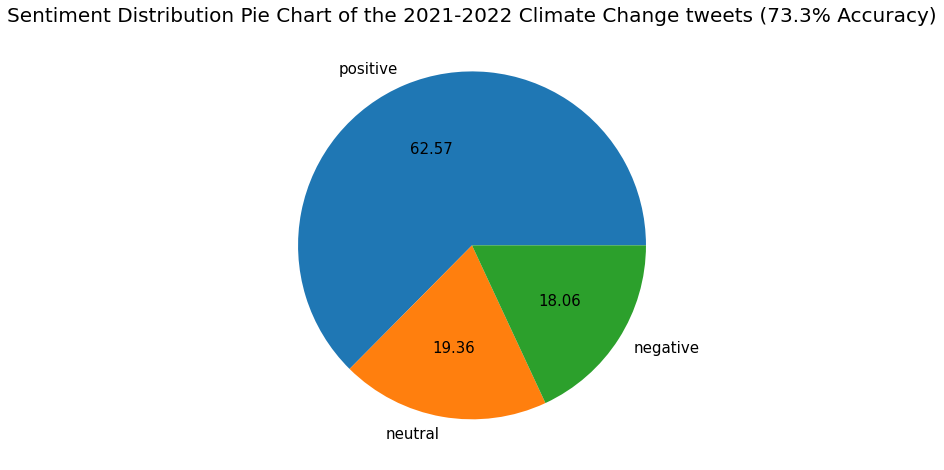

In [231]:
plt.figure(figsize = (8, 8))
values = pd.DataFrame(test_predict).value_counts().values
labels = ['positive', 'neutral', 'negative']
plt.pie(values, labels=labels, textprops={'fontsize': 15}, autopct="%.2f")
plt.title('Sentiment Distribution Pie Chart of the 2021-2022 Climate Change tweets (73.3% Accuracy)', fontsize=20)
plt.show()

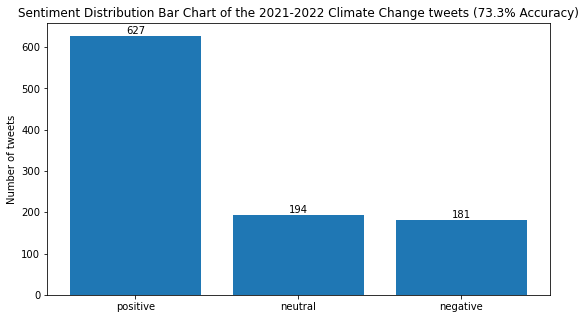

In [232]:
labels = ['positive', 'neutral', 'negative']
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar([-1, 0, 1], values)
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(labels)
ax.set_ylabel('Number of tweets')
ax.set_title("Sentiment Distribution Bar Chart of the 2021-2022 Climate Change tweets (73.3% Accuracy)")
ax.bar_label(bars)

plt.show()

### 5.2 Predicting Sentiments of tweets from 5 years ago (2016-2017)

In [233]:
logisticRegr = LogisticRegression(C=1000000,solver='lbfgs',max_iter=1000000)
logisticRegr.fit(x_train,y_train)
score = logisticRegr.score(x_test,y_test)
testing = pd.read_csv('5yearsago.csv')
#Tokenize the text data using RegexpTokenizer
textdata = testing['text']
n = len(textdata)
tokenizedtext = []

for i in range(n):
    #Convert text data to lowercase
    lower = textdata.iloc[i].lower()
    
    #Tokenize
    wordsarray = tokenizer.tokenize(lower)
    tokenizedtext.append(wordsarray)
#Removing stop words using nlkt
englishstopwords = set(stopwords.words('english'))
shortertext = []

for tweet in tokenizedtext:
    shortertweet = []
    for word in tweet:
        if word not in englishstopwords:
            word = word.strip()
            if (word.isdigit() == False and len(word) >= 2):
                shortertweet.append(word)
    shortertext.append(shortertweet)
#Stemming using PorterStemmer
stemmedtext = []
for tweet in shortertext:
    stemmedwords = []
    for word in tweet:
        stemmedwords.append(porterstemmer.stem(word))
    convertback = ' '.join(stemmedwords)
    stemmedtext.append(convertback)
#Vectorizing the text data using TFIDvectorizer for Modelling
vectorizedtesting = tfid.transform(stemmedtext)

test_predict = logisticRegr.predict(vectorizedtesting)

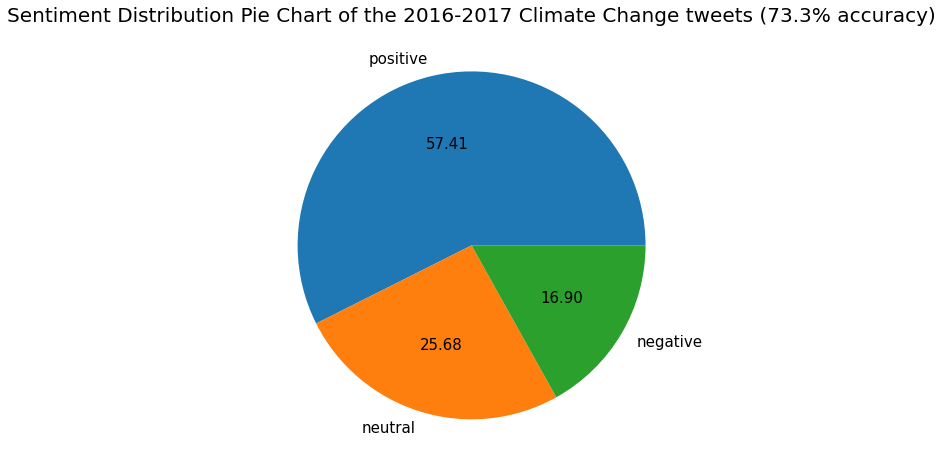

In [234]:
plt.figure(figsize = (8, 8))
values = pd.DataFrame(test_predict).value_counts().values
labels = ['positive', 'neutral', 'negative']
plt.pie(values, labels=labels, textprops={'fontsize': 15}, autopct="%.2f")
plt.title('Sentiment Distribution Pie Chart of the 2016-2017 Climate Change tweets (73.3% accuracy)', fontsize=20)
plt.show()

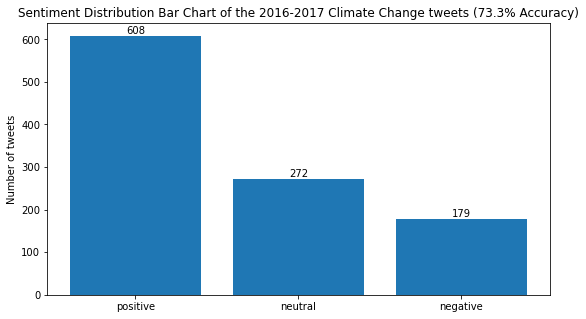

In [235]:
labels = ['positive', 'neutral', 'negative']
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar([-1, 0, 1], values)
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(labels)
ax.set_ylabel('Number of tweets')
ax.set_title("Sentiment Distribution Bar Chart of the 2016-2017 Climate Change tweets (73.3% Accuracy)")
ax.bar_label(bars)

plt.show()